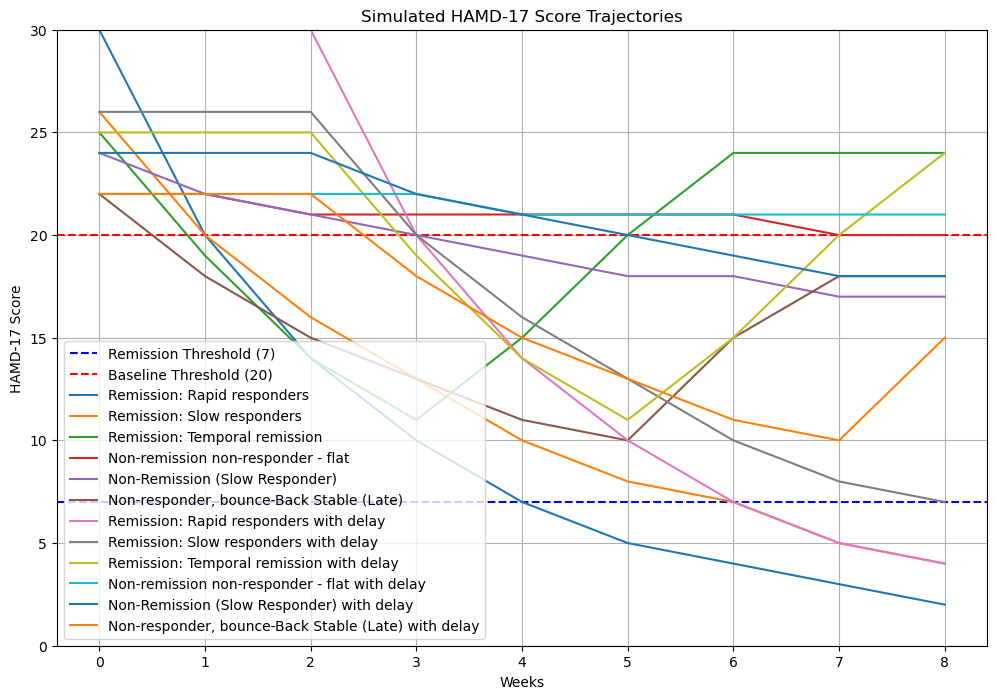

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def hamd_model_min_params(delay, baseline, reduction_rate, residual_score, rebound_start=None, rebound_rate=0, rebound_steepness=5, stable_bounce=False, stable_value=None, weeks=8):
    """
    Simulates HAMD-17 score changes with clinically interpretable parameters.

    Args:
        baseline (int): The initial HAMD-17 score at the start of treatment (week 0).
        reduction_rate (float): The rate of the initial exponential decrease in the HAMD-17 score.
                               A higher value means a faster initial response to treatment.
        residual_score (int): The lowest HAMD-17 score the patient would reach if there were no rebound.
                               This represents the potential treatment effect in the absence of worsening.
        rebound_start (int, optional): The week at which the rebound starts. If None, no rebound is modeled.
        rebound_rate (float, optional): The rate of increase in the HAMD-17 score during the rebound.
                                      A higher value means a faster worsening of symptoms.
        rebound_steepness (float, optional): Controls how abruptly the rebound starts. Higher values make the rebound more sudden.
        stable_bounce (bool, optional): If True, the rebound stabilizes at stable_value. If False, the rebound continues.
        stable_value (int, optional): The HAMD-17 score at which the stable bounce-back plateaus. Only used if stable_bounce is True.
        weeks (int, optional): The total number of weeks to simulate.

        delay (int): delayed for the number of weeks to see response. 
        
    Simulate five groups:
    Initial score > 20.
    1.	Rapid responders:
        Achieve a 50% reduction from their initial score early (typically within the first 4 weeks).
        Characterized by a steep slope (< -1.5) in the reduction of scores.
    2.	Slow responders:
        Achieve a 50% reduction from their initial score later (typically after the first 4 weeks).
        Characterized by a more gradual slope.
    3.	Remission:
        3.1 True remission: Scores drop below 7 and remain below 7 without rebound.
        3.2 Temporal remission: Scores drop below 7 but later rebound above 7.
    4.	Non-responder:
        Individuals who meet none of the above criteria.


    Returns:
        list: A list of HAMD-17 scores for each week.
    """
    hamd_scores = []
    for week in range(weeks + 1):
        if week <= delay:  # Keep score at baseline during the delay period
            hamd = baseline
        else:
            effective_week = week - delay #calculate the effective week after delay
            hamd = residual_score + (baseline - residual_score) * np.exp(-reduction_rate * effective_week)

            if rebound_start is not None:
                rebound_factor = 1 / (1 + np.exp(-rebound_steepness * (effective_week - rebound_start)))
                rebound_increase = rebound_rate * (effective_week - rebound_start) * rebound_factor
                hamd += rebound_increase

            if stable_bounce and rebound_start is not None and effective_week >= rebound_start:
                hamd = min(hamd, stable_value)

        hamd_scores.append(int(round(hamd)))
    return hamd_scores
# Scenario Parameters
scenarios = {
    "Remission: Rapid responders": {"delay": 0, "baseline": 30, "reduction_rate": 0.4, "residual_score": 1},    # achieve 50% reduction of baseline score 20-35, reduction rate needs > 0.4
    "Remission: Slow responders": {"delay": 0, "baseline": 26, "reduction_rate": 0.25, "residual_score": 1},     # smaller reduction rate < 0.25, is required to reach remission in 8 weeks, given residual of 1
    "Remission: Temporal remission":  {"delay": 0, "baseline": 25, "reduction_rate": 0.3, "residual_score": 1, "rebound_start": 3, "rebound_rate": 7, "stable_bounce": True, "stable_value": 24},  # remission but bounce back
    "Non-remission non-responder - flat":   {"delay": 0, "baseline": 22, "reduction_rate": 0.1, "residual_score": 19},
    "Non-Remission (Slow Responder)": {"delay": 0, "baseline": 24, "reduction_rate": 0.2, "residual_score": 15},
    "Non-responder, bounce-Back Stable": {"delay": 0, "baseline": 22, "reduction_rate": 0.3, "residual_score": 7, "rebound_start": 5, "rebound_rate": 6, "stable_bounce": True, "stable_value": 18},
    "Remission: Rapid responders with delay": {"delay": 2, "baseline": 30, "reduction_rate": 0.4, "residual_score": 1},    # achieve 50% reduction of baseline score 20-35, reduction rate needs > 0.4
    "Remission: Slow responders with delay": {"delay": 2, "baseline": 26, "reduction_rate": 0.25, "residual_score": 1},     # smaller reduction rate < 0.25, is required to reach remission in 8 weeks, given residual of 1
    "Remission: Temporal remission with delay":  {"delay": 2, "baseline": 25, "reduction_rate": 0.3, "residual_score": 1, "rebound_start": 3, "rebound_rate": 7, "stable_bounce": True, "stable_value": 24},  # remission but bounce back
    "Non-remission non-responder - flat with delay":   {"delay": 2, "baseline": 22, "reduction_rate": 0.1, "residual_score": 19},
    "Non-Remission (Slow Responder) with delay": {"delay": 2, "baseline": 24, "reduction_rate": 0.2, "residual_score": 15},
    "Non-responder, bounce-Back Stable with delay": {"delay": 2, "baseline": 22, "reduction_rate": 0.3, "residual_score": 7, "rebound_start": 5, "rebound_rate": 6, "stable_bounce": True, "stable_value": 18},
}

    # residue of 1 and reduction rate > 0.25 are both required to reach remission in 8 weeks

weeks = 8

# Plotting


plt.figure(figsize=(12, 8))
plt.xlabel("Weeks")
plt.ylabel("HAMD-17 Score")

plt.axhline(y=7, color='blue', linestyle='--', label='Remission Threshold (7)')  # Blue dashed line at y=7
plt.axhline(y=20, color='red', linestyle='--', label='Baseline Threshold (20)')    # Red dashed line at y=20

plt.title("Simulated HAMD-17 Score Trajectories")
plt.grid(True)
plt.xticks(range(weeks + 1))
plt.ylim(0, 30)

for scenario_name, params in scenarios.items():
    scores = hamd_model_min_params(**params, weeks=weeks)
    plt.plot(range(weeks + 1), scores, label=scenario_name)

plt.legend()
plt.show()